In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
df = pd.read_csv("iris.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
column_map = {
    'sepallengthcm': 'sepal_length',
    'sepallength': 'sepal_length',
    'sepallength(cm)': 'sepal_length',
    'sepallength_cm': 'sepal_length',
    'sepallength_cm': 'sepal_length',
    'sepalwidthcm': 'sepal_width',
    'sepalwidth': 'sepal_width',
    'sepalwidth_cm': 'sepal_width',
    'petallengthcm': 'petal_length',
    'petallength': 'petal_length',
    'petallength_cm': 'petal_length',
    'petalwidthcm': 'petal_width',
    'petalwidth': 'petal_width',
    'petalwidth_cm': 'petal_width'
}
df.rename(columns=column_map, inplace=True)
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = df['species'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16)


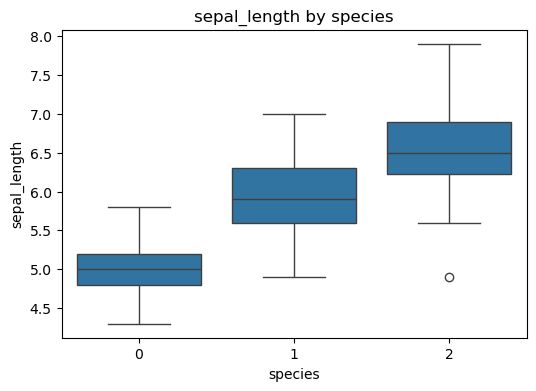

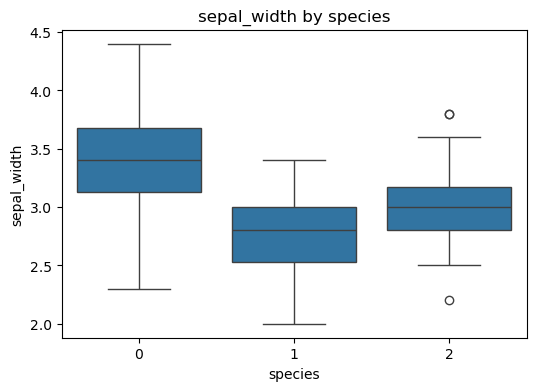

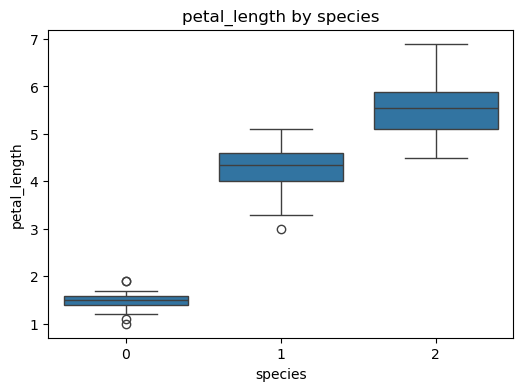

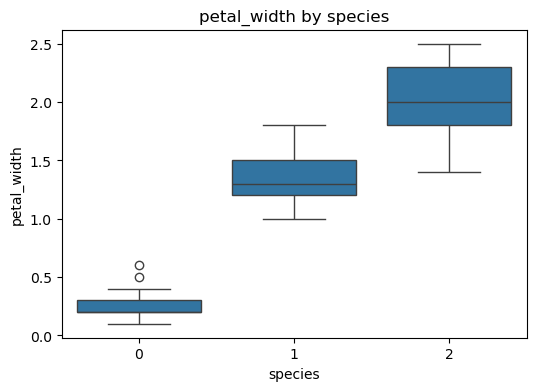

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='species', y=feature, data=df)
    plt.title(f'{feature} by species')
    plt.show()

In [19]:
import torch.nn as nn
import torch.nn.functional as F
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(1, 101):
    model.train()
    epoch_loss = 0
    correct = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()
    train_loss = epoch_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for xb, yb in test_loader:
            preds = model(xb)
            test_loss += criterion(preds, yb).item()
            correct += (preds.argmax(1) == yb).sum().item()
        test_loss /= len(test_loader)
        test_acc = correct / len(test_loader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

Epoch 10: Train Loss = 0.2327, Test Loss = 0.2769, Train Acc = 0.9333, Test Acc = 0.8667
Epoch 20: Train Loss = 0.1003, Test Loss = 0.1441, Train Acc = 0.9667, Test Acc = 0.9333
Epoch 30: Train Loss = 0.0621, Test Loss = 0.1050, Train Acc = 0.9750, Test Acc = 0.9333
Epoch 40: Train Loss = 0.0547, Test Loss = 0.0905, Train Acc = 0.9750, Test Acc = 0.9333
Epoch 50: Train Loss = 0.0487, Test Loss = 0.0914, Train Acc = 0.9833, Test Acc = 0.9333
Epoch 60: Train Loss = 0.0463, Test Loss = 0.0878, Train Acc = 0.9833, Test Acc = 0.9333
Epoch 70: Train Loss = 0.0428, Test Loss = 0.0881, Train Acc = 0.9833, Test Acc = 0.9667
Epoch 80: Train Loss = 0.0619, Test Loss = 0.0878, Train Acc = 0.9750, Test Acc = 0.9667
Epoch 90: Train Loss = 0.0559, Test Loss = 0.0977, Train Acc = 0.9833, Test Acc = 0.9000
Epoch 100: Train Loss = 0.0370, Test Loss = 0.0917, Train Acc = 0.9833, Test Acc = 0.9667


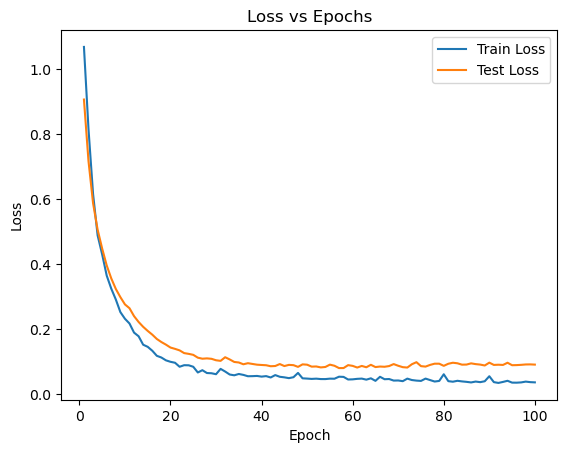

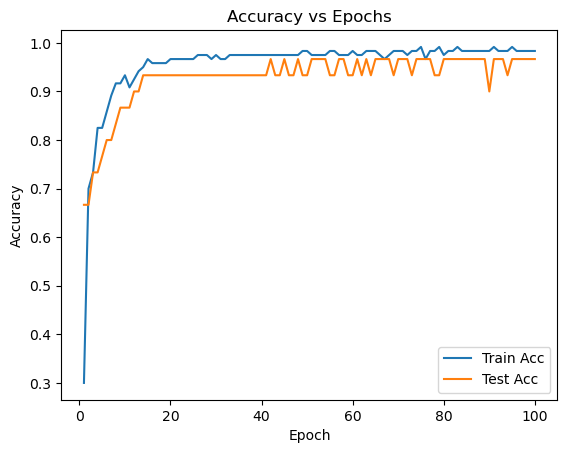

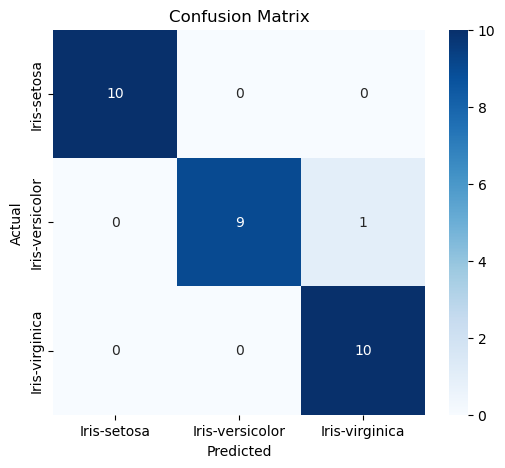

In [21]:
plt.figure()
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()
plt.figure()
plt.plot(range(1, 101), train_accuracies, label='Train Acc')
plt.plot(range(1, 101), test_accuracies, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()
from sklearn.metrics import confusion_matrix
import seaborn as sns
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).argmax(1).numpy()
    cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()